# Classification of Hypnotic Depth

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne

import torch
import keras
import xarray as xr
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
import re
from sklearn.preprocessing import RobustScaler, StandardScaler

import mne


# helper functions
def preprocess_data(data, baseline_mean):
    # Step 1: Baseline correction (subtract the mean of the first 0.5 seconds for each channel) 
    data_corrected = data - baseline_mean
    
    # Step 2: Robust Scaler (normalize using median and IQR)
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data_corrected.T)
    
    # Step 3: Normalization (z-score normalization)
    normalizer = StandardScaler()
    data_normalized = normalizer.fit_transform(data_scaled).T  # Transpose for sklearn, then back
    
    # Step 4: Clamp values greater than 20 standard deviations (becuause of the normalization at the previous step sd is 1)
    std_threshold = 20
    data_clamped = np.clip(data_normalized, -std_threshold, std_threshold)
    
    return data_clamped

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


## DATA

In [3]:
EEG_data_path = Path('/Volumes/Extreme SSD/PhD/OTKA study1/EEG data/BIDS/')

all_data = {}

# is it because of the resampling that there are different number of timepoints?

for root in sorted(EEG_data_path.glob('sub-*')):
    sub_path  = root / 'ses-01/eeg/'
    for data_path in sorted(sub_path.glob('*_eeg.vhdr')):
        bids_id, task = re.match(r'.*/sub-(.*)_ses-01_task-(.*)_eeg.vhdr', str(data_path)).groups()
        if task == 'baseline1':
            print(f'>>>>>>Processing {bids_id} {task}')
            epoch = mne.io.read_raw_brainvision(data_path, verbose=False, eog=['EOG1', 'EOG2'], misc=['ECG'])
            epoch.pick(picks='eeg', exclude=['M1', 'M2'])
            epoch.resample(128)
            epoch = epoch.get_data()
            baseline_mean = epoch.mean(axis=1, keepdims=True)
            continue
    
        if task.__contains__('experience'):
            print(f'>>>>>>Processing {bids_id} {task}')
            epoch = mne.io.read_raw_brainvision(data_path, verbose=False, eog=['EOG1', 'EOG2'], misc=['ECG'])
            epoch.pick(picks='eeg', exclude=['M1', 'M2'])
            epoch.resample(128)
            data = epoch.get_data()
            data_clamped = preprocess_data(data, baseline_mean)
            all_data[f'sub-{bids_id}_{task}'] = data_clamped

In [142]:
## Prepare the data to be converted and stored as a data array

# trim all the data in the dictionary to the minimum length
min_len = min([i.shape[1] for i in list(all_data.values())])
all_data = {k: v[:, :min_len] for k, v in all_data.items()}

# there are two missing tasks for sub-52, we fill them with zeros so th
all_data['sub-52_experience2'] = np.zeros_like(all_data['sub-52_experience1'])
all_data['sub-52_experience3'] = np.zeros_like(all_data['sub-52_experience1'])
data = np.array(list(all_data.values()))
data = data.reshape(52, 4, 56, -1)  # 52 subjects, 4 conditions, 56 channels, time
# rearranging the data for the last participant whose experience 2 and 3 data is missing
data[-1, -1] = data[-1, -3]  
data[-1, -3] = data[-1, -2]

data = xr.DataArray(data, 
                    dims=('subject', 'tasks', 'channel', 'time'),
                    coords={'subject': np.unique([i.split('_')[0] for i in all_data.keys()]),
                            'tasks': ['experience1', 'experience2', 'experience3', 'experience4'],
                            'channel': epoch.ch_names,
                            'time': np.arange(min_len)}
                            )

# data.to_netcdf('/Users/yeganeh/Codes/otka_data/EEG/experiment_EEG_data.nc5', engine='h5netcdf')

## MODEL

In [2]:
# open EEG data
EEG_data = xr.open_dataarray('/Users/yeganeh/Codes/otka_data/EEG/experiment_EEG_data.nc5')
only_real_hypnosis = False

# open session data
session_data = pd.read_csv('/Users/yeganeh/Codes/otka_data/behavioral/behavioral_data.csv')
described_as_hyp = session_data.query('description == "hypnosis"')[['bids_id', 'session', 'score', 'procedure']].set_index('bids_id')
n_sessions = 2
if only_real_hypnosis:
    described_as_hyp = described_as_hyp.query('procedure in ["relaxation", "confusion"]')
    n_sessions = 1

In [5]:
# # including only 10 subjects
from scipy.signal import butter, sosfilt
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.model_selection import train_test_split

n_subject = 51
time_dim = 512
filtering = True
channels = ['Oz', 'Fz', 'Cz', 'Pz', 'Fp1', 'Fp2', 'F3', 'F4']

X_input = EEG_data.sel(subject=EEG_data.subject[:n_subject], channel=channels).to_numpy()

# including only hypnosis sessions
X_input_hyp =  np.zeros([n_subject, n_sessions, len(channels), X_input.shape[-1]])
for i in range(X_input.shape[0]):
    ses = described_as_hyp.loc[i+1, 'session'].values - 1
    X_input_hyp[i] = X_input[i, ses, :, :]

# preparing x
if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    X_input_hyp = sosfilt(sos, X_input_hyp, axis=-1)

X_input_hyp = torch.tensor(X_input_hyp.squeeze()).unfold(-1, time_dim, time_dim).permute(0, 1, 3, 4, 2)
train_ids, test_ids = train_test_split(np.arange(n_subject), test_size=0.2, random_state=0)  # TODO
X_train, X_test = X_input_hyp[train_ids].flatten(0, 1).flatten(0, 1), X_input_hyp[test_ids].flatten(0, 1).flatten(0, 1)


# prepare y
described_as_hyp['binary_scores'] = described_as_hyp['score'].apply(lambda x: 0 if x>6 else 1)
y_train = described_as_hyp.loc[:n_subject, 'binary_scores'].loc[train_ids + 1.0].values  # TODO +1 because the bids_id are not zero based unlike the indices (make sure that it does not mess up the order)
y_test = described_as_hyp.loc[:n_subject, 'binary_scores'].loc[test_ids + 1.0].values
y_train = torch.tensor(y_train).reshape(-1, 1).repeat(1, X_input_hyp.shape[2]).flatten(0, 1)
y_test = torch.tensor(y_test).reshape(-1, 1).repeat(1, X_input_hyp.shape[2]).flatten(0, 1)

In [14]:
y = described_as_hyp.loc[:n_subject, 'binary_scores']
groups = y.indexto_numpy() - 1  # -1 because the bids_id are not zero based unlike the indices
y = y.values
x = X_input_hyp.flatten(0, 1)

In [16]:
X_input_hyp.flatten(0, 1).shape, y.shape, groups.shape

(torch.Size([102, 104, 512, 8]), (102,), (102,))

In [28]:
from sklearn.model_selection import StratifiedGroupKFold

# prepare cross validation
n_splits = 5
group_kfold = StratifiedGroupKFold(n_splits=n_splits)
train_val_splits = []
for train_idx, val_idx in group_kfold.split(X_input_hyp.flatten(0, 1), y, groups=groups):
    train_val_splits.append((train_idx, val_idx))

In [17]:
np.unique(y_train, return_counts=True)[1] / len(y_train), np.unique(y_test, return_counts=True)[1] / len(y_test)

(array([0.4625, 0.5375]), array([0.5, 0.5]))

In [33]:
# # model
# from src.EEGModalNet.models.common import ResidualBlock
# import keras
# from keras import layers
# from keras import regularizers
# l2_lambda = 0.01
dropout_rate = 0.2

# class Critic(keras.Model):
#     def __init__(self, time_dim, feature_dim, use_sublayer):
#         super(Critic, self).__init__()

#         self.input_shape = (time_dim, feature_dim)
#         self.use_sublayer = use_sublayer

#         self.model = keras.Sequential([
#             keras.Input(shape=self.input_shape),
#             ResidualBlock(feature_dim * 4, 5, activation='relu'),
#             layers.Conv1D(2, 5, padding='same', activation='relu', name='conv3', kernel_regularizer=regularizers.L2(l2_lambda)),
#             layers.Conv1D(1, 5, padding='same', activation='relu', name='conv4', kernel_regularizer=regularizers.L2(l2_lambda)),
#             layers.Flatten(name='dis_flatten'),
#             layers.Dense(512, name='dis_dense1', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
#             layers.Dropout(dropout_rate),
#             layers.Dense(128, name='dis_dense2', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
#             layers.Dropout(dropout_rate),
#             layers.Dense(32, name='dis_dense3', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
#             layers.Dropout(dropout_rate),
#             layers.Dense(8, name='dis_dense4', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
#             layers.Dropout(dropout_rate),
#             layers.Dense(1, name='sigmoid', activation='sigmoid', kernel_regularizer=regularizers.L2(l2_lambda))
#         ], name='critic')
    
#     def call(self, inputs):
#         return self.model(inputs)

# torch.cuda.empty_cache() # clear GPU memory before training
# model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)

# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9861 - loss: 0.1471 - val_accuracy: 0.6661 - val_loss: 1.4558
Epoch 2/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9861 - loss: 0.1455 - val_accuracy: 0.6600 - val_loss: 1.4330
Epoch 3/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9868 - loss: 0.1426 - val_accuracy: 0.6538 - val_loss: 1.4477
Epoch 4/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9836 - loss: 0.1468 - val_accuracy: 0.6477 - val_loss: 1.4569
Epoch 5/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9861 - loss: 0.1441 - val_accuracy: 0.6556 - val_loss: 1.3685
Epoch 6/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9890 - loss: 0.1333 - val_accuracy: 0.6569 - val_loss: 1.3371
Epoch 7/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9835 - loss: 0.1466 - val_accuracy: 0.6565 - val_loss: 1.5202
Epoch 8/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9889 - loss: 0.1307 - val_accu

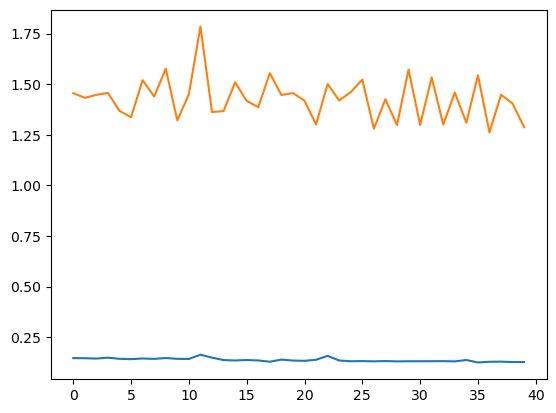

In [34]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

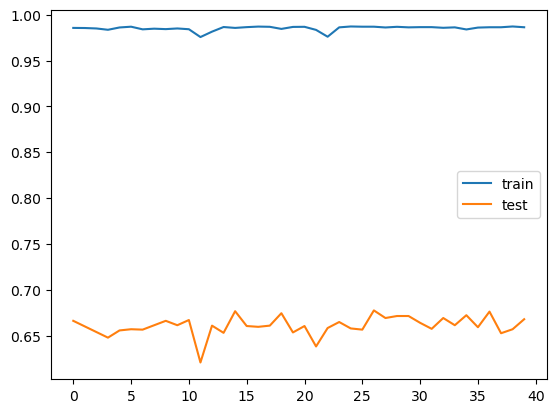

In [35]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

In [37]:
# save model & model config
model_path = 'data/trainings/training_19092024/'
model_name = 'HD_classify_'+ '8_channels'
model.save(model_path+f'{model_name}.model.keras')
model_config = model.model.get_config()
import json
with open(f'{model_name}_config.json', 'w') as f:
    json.dump(model_config, f)

In [28]:
# add all the channel names into one string
channels = ['Oz', 'Fz', 'Cz', 'Pz', 'Fp1', 'Fp2', 'F3', 'F4']

[ch + '-' for ch in channels]

['Oz-', 'Fz-', 'Cz-', 'Pz-', 'Fp1-', 'Fp2-', 'F3-', 'F4-']